## NN Adv Assignment

In [245]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F

### TensorFlow

### Load Data

In [246]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

In [247]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [248]:
train['label'].nunique()

10

In [249]:
test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [250]:
X = train.iloc[:, 1:].values
y = train.iloc[:, 0].values

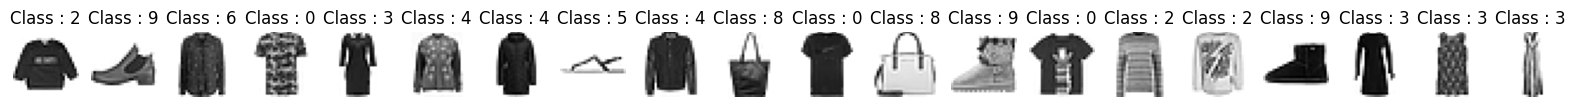

In [251]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X[idx].reshape(28, 28), cmap='gray_r')
  plt.title(f'Class : {y[idx]}')

In [252]:
X_test = test.iloc[:, 1:].values
y_test = test.iloc[:, 0].values

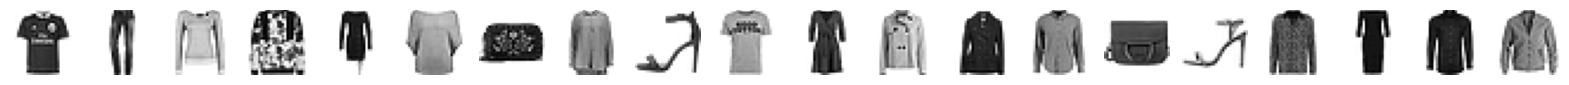

In [253]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X_test[idx].reshape(28, 28), cmap='gray_r')

### Train-Test Split

In [254]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 16, stratify = y, shuffle = True)

## Normalization
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)

X_val = torch.FloatTensor(X_val)
y_val = torch.LongTensor(y_val)

X_test = torch.FloatTensor(X_test)

In [255]:
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

print(DEVICE)

cuda


In [256]:
#Batch Size는 조정 가능합니다.
BATCH_SIZE = 1024
#Epoch는 고정해주세요.
EPOCHS = 15

In [257]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class DataSet(Dataset):
  def __init__(self, image, label = None):
    super(DataSet, self).__init__()
    self._image = image
    self._label = label

  def __len__(self):
    return len(self._image)

  def __getitem__(self, idx):
    if self._label is None:
      image = self._image[idx]
      return image

    else:
      image = self._image[idx]
      label = self._label[idx]

      return image, label

In [258]:
train_dataset = DataSet(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

val_dataset = DataSet(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

test_dataset = DataSet(X_test)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, drop_last = False)

## 직접 Network를 설계하고, 성능을 시험해보자.

### 참고: https://wikidocs.net/63618

In [275]:
from typing import Any, Optional
import lightning as pl
from lightning.pytorch.utilities.types import STEP_OUTPUT
class MyNet(pl.LightningModule):
    def __init__(self) -> None:
        super().__init__()
        self.model=nn.Sequential(
            nn.Linear(784, 256),
            
            
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 10),
            nn.Softmax(dim=1)
        )
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []
        self.epoch = []

        
    def forward(self, x):
        #여기에 Forward 함수 삽입: __init__에서 추가한 Layer에 순전파시킴
        #Ex. x = self.layer1(x)
        x=self.model(x) 
        return x
    
    def training_step(self, batch, batch_idx):
        x,y=batch
        y_hat=self.forward(x)
        loss=F.cross_entropy(y_hat,y)
        # get accruacy
        preds = torch.argmax(y_hat, dim=1)
        acc = (preds == y).float().mean()

        self.training_step_outputs.append({'loss': loss, 'acc': acc,'epoch':self.current_epoch+1})
        l1loss=self.l1loss()
        loss=loss+l1loss*0.00001
        return loss
    
    def on_train_epoch_end(self) -> None:
        outputs=self.training_step_outputs[-1]
        loss=outputs['loss']
        acc=outputs['acc']
        epoch=outputs['epoch']
        self.train_loss.append(loss.item())
        self.train_acc.append(acc.item())
        self.epoch.append(epoch)
        return super().on_train_epoch_end()
    
    def validation_step(self, batch, batch_idx):
        x,y=batch
        y_hat=self.forward(x)
        loss=F.cross_entropy(y_hat,y)
        # get accruacy
        preds = torch.argmax(y_hat, dim=1)
        acc = (preds == y).float().mean()

        self.validation_step_outputs.append({'loss': loss, 'acc': acc})
        
    def on_validation_epoch_end(self):
        if self.current_epoch>=self.trainer.max_epochs-1:
            return
        
        outputs=self.validation_step_outputs[-1]
        loss=outputs['loss']
        acc=outputs['acc']

        self.val_loss.append(loss.item())
        self.val_acc.append(acc.item())
        
    def configure_optimizers(self) -> Any:
        # Adam
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)  
        return optimizer
    
    def l1loss(self):
        l1_norm = 0.

        for name, param in self.model.named_parameters():

            l1_norm += torch.sum(torch.abs(param))

        return l1_norm
    
model = MyNet().to(DEVICE)
#적절한 optimizer를 선택: torch.optim의 적절한 Optimizer를 사용


In [276]:
trainer = pl.Trainer(max_epochs=EPOCHS)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [277]:
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 235 K 
-------------------------------------
235 K     Trainable params
0         Non-trainable params
235 K     Total params
0.944     Total estimated model params size (MB)


/opt/conda/envs/study/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:486: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/opt/conda/envs/study/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/conda/envs/study/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpu

Epoch 0:   0%|          | 0/47 [00:00<?, ?it/s] 

/opt/conda/envs/study/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


TypeError: L1Loss.forward() missing 1 required positional argument: 'target'

In [271]:
result_df = pd.DataFrame()
result_df['EPOCH'] = model.epoch
result_df['Train Loss'] = model.train_loss
result_df['Train Accuracy'] = model.train_acc
result_df['Val Loss'] = model.val_loss
result_df['Val Accuracy'] = model.val_acc

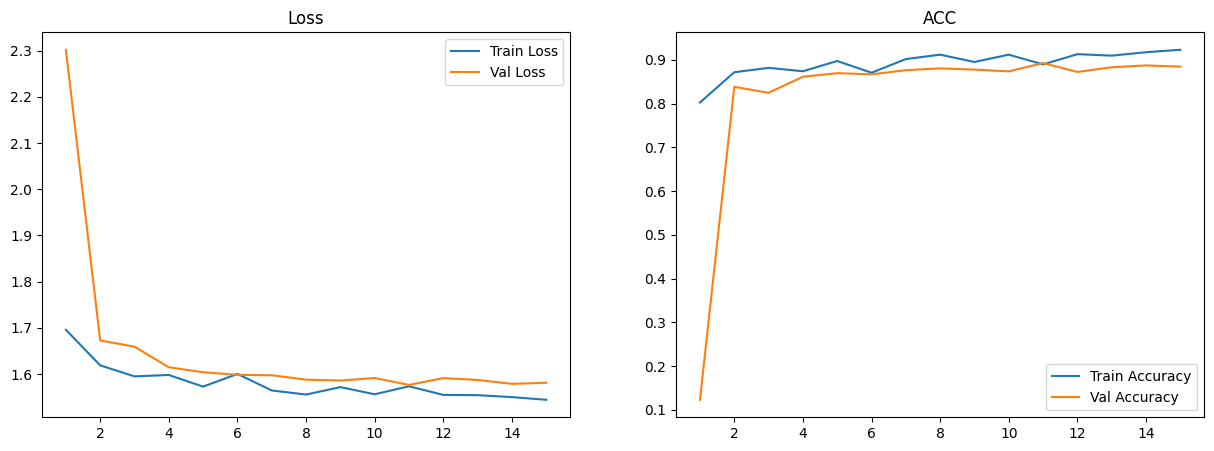

In [274]:

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
axes[0].plot(result_df['EPOCH'], result_df['Val Loss'], label='Val Loss')

axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(result_df['EPOCH'], result_df['Train Accuracy'], label='Train Accuracy')
axes[1].plot(result_df['EPOCH'], result_df['Val Accuracy'], label='Val Accuracy')

axes[1].legend()
axes[1].set_title('ACC')

plt.show()

## 결론을 작성해주세요:

In [ ]:
'''

'''